# Submitting a pulser Sequence to a QPU on OVH

This notebook illustrates how to use Pulser to:
- build a sequence to prepare an [antiferromagnetic state in an Ising-like model](https://docs.pasqal.com/pulser/tutorials/creating/#Adiabatic-preparation-of-an-Anti-Ferromagnetic-State).
- submit this Sequence to a QPU using the OVHConnection

We begin by importing some basic modules:

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time

from pulser import Pulse, Sequence, QPUBackend, InterpolatedWaveform, Register
from pulser.backend.remote import JobParams

from pulser_pasqal import OVHConnection

Let's follow [Pulser step-by-step guide to pulse Sequence creation](https://docs.pasqal.com/pulser/programming/#writing-a-pulser-program):

## Pick a Device

To prepare an AFM state, you need a Device containing at least a `Rydberg.Global` channel.
Since we want to run this Sequence on a QPU, let's connect to the Pasqal cloud platform and see the Devices that are available.

The OVHConnection can be used to access the Pasqal cloud platform, and fetch the available devices, and their associated QPUs.

In [26]:
connection = OVHConnection()

OVHConnection.fetch_available_devices returns a dictionnary, associating to each QPU available through the cloud, the Device that it implements.

In [27]:
connection.fetch_available_devices()

{'FRESNEL': Fresnel}

Pick the device you want to address. Its specifications can be obtained using `print_specs`. For this tutorial, we will pick Fresnel.

In [28]:
device = connection.fetch_available_devices()["FRESNEL"]
device.print_specs()

----------------------
Fresnel Specifications
----------------------

Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 100
 - Maximum distance from origin: 50 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 60
 - Maximal number of traps: 200
 - Minimum layout filling fraction: 0.35
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 500

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=62.83185307179586, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=6000, min_avg_amp=0.5654866776461628, mod_bandwidth

## Define a Register

If the device requires a layout, you have to define the Register from a RegisterLayout. Pulser provides the `with_automatic_layout` method to generate a layout automatically from a given Register.

Let's define a ring of atoms, spaced by 5.0 µm and generate an automatic layout with it.

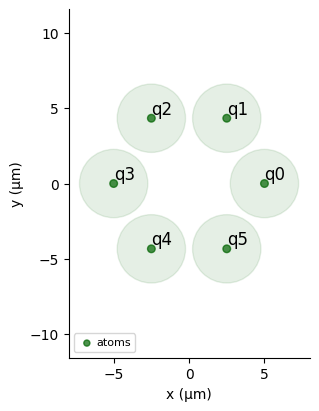

In [29]:
# Define a ring of atoms distanced by a blockade radius distance:
L = 6  # number of atoms
coords = (
    5.0
    / (2 * np.sin(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

# ring, periodic register
reg = Register.from_coordinates(coords, prefix="q").with_automatic_layout(device)

Omega_max = 0.9 * 2 * device.rabi_from_blockade(5.0)  # Spacing between atoms
reg.draw(
    blockade_radius=device.rydberg_blockade_radius(Omega_max), draw_half_radius=True
)

We can now initialize a Sequence, that checks that the register matches the Device's constraints:

In [30]:
sequence = Sequence(reg, device)

## Declaring the Channel

We need a `Rydberg.Global` channel for our computation:

In [31]:
sequence.declare_channel("ising", "rydberg_global")

At this stage, our Sequence implements the [Ising Hamiltonian](https://docs.pasqal.com/pulser/programming/#ising-hamiltonian).

## Add the pulses

Let’s now define the [driving Hamiltonian](https://docs.pasqal.com/pulser/programming/#driving-hamiltonian) to prepare an AFM state. We use here time-varying Rabi frequency and detuning that were optimized to generate an AFM state. They are defined with [InterpolatedWaveforms](https://docs.pasqal.com/pulser/tutorials/interpolated_wfs/):

In [32]:
U = Omega_max / 2.0

T = 2  # us
params = [T] + (
    U * np.array([0.16768532, 0.2, 0.2, -1.0, -0.54656236, 0.05762063, 0.3673201, 1.0])
).tolist()

interpolated_pulse = Pulse(
    InterpolatedWaveform(
        T * 1000,
        U * np.array([1e-9, 0.16768532, 0.2, 0.2, 1e-9]),
        times=np.linspace(0, 1, 5),
    ),
    InterpolatedWaveform(
        T * 1000,
        U * np.array([-1.0, -0.54656236, 0.05762063, 0.3673201, 1.0]),
        times=np.linspace(0, 1, 5),
    ),
    0,
)

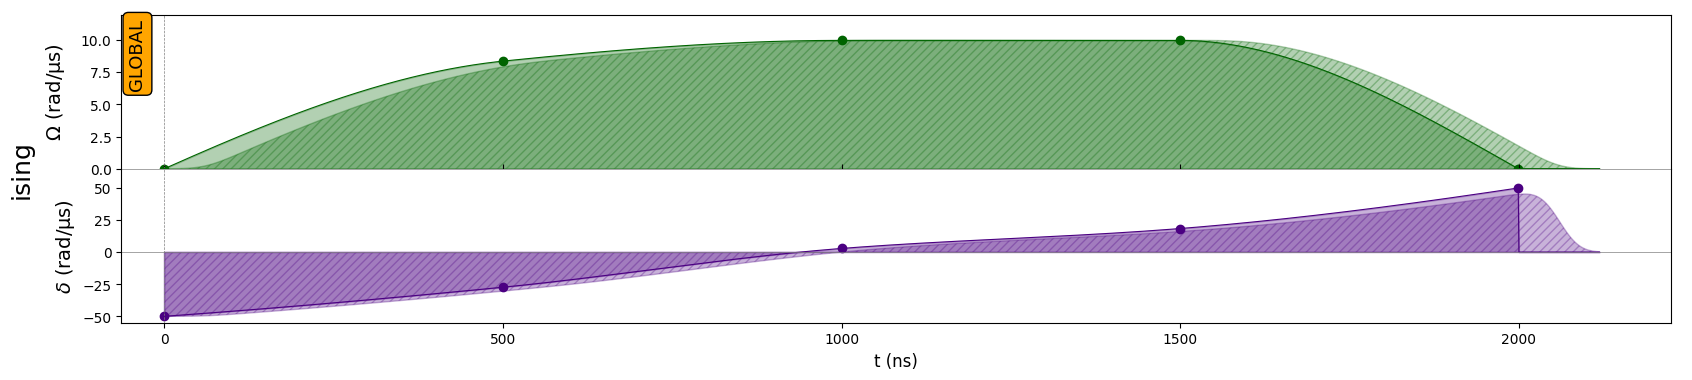

In [33]:
sequence.add(interpolated_pulse, "ising")

sequence.draw()

## Submitting to the QPU

***This notebook will run on a real-hardware QPU and the effective QPU time needed to run this notebook will take around 2 minutes.***

Once built, pulser Sequences can be executed on pulser Backends. To execute the Sequence on a QPU connected to OVH, let's use a  QPUBackend, taking the OVHConnection as a connection:

In [34]:
backend = QPUBackend(sequence, connection=connection)
# Alternatively, run on a cloud emulator
# from pulser_pasqal.backends import EmuFreeBackendV2
# backend = EmuFreeBackendV2(sequence, connection=connection)

You can then use the method `run` of the backend to launch a Batch of Jobs execution, defined by their number of runs, and eventually by assigning a value to each variable if the [Sequence is parametrized](https://docs.pasqal.com/pulser/tutorials/paramseqs/) (parametrized sequence can be used to run variational Jobs to improve the quality of the results, see an example [here](https://docs.pasqal.com/pulser/tutorials/optimization/). This will return a pulser `RemoteResults`, that you can use to get your jobs once they are executed.

In [35]:
result = backend.run([JobParams(runs=100)])
status = result.get_batch_status()
while status.name not in ("DONE", "ERROR"):
    print(f"Job status is {status.name}, waiting...")
    time.sleep(5)
    status = result.get_batch_status()
print(f"Job status is {status.name}!")

Job status is PENDING, waiting...
Job status is RUNNING, waiting...
Job status is RUNNING, waiting...
Job status is RUNNING, waiting...
Job status is RUNNING, waiting...
Job status is RUNNING, waiting...
Job status is RUNNING, waiting...
Job status is DONE!


In [36]:
result.get_available_results()

{'13b8de6e-c70c-4af8-96d9-2138231ade6e': SampledResult(atom_order=('q0', 'q1', 'q2', 'q3', 'q4', 'q5'), total_duration=0, _results={UUID('00000000-0000-0000-0000-000000000000'): [{'010101': 246, '101010': 251, '001010': 1, '100010': 1, '010001': 1}]}, _times={UUID('00000000-0000-0000-0000-000000000000'): [1.0]}, _tagmap={'bitstrings': UUID('00000000-0000-0000-0000-000000000000')}, meas_basis='ground-rydberg', bitstring_counts={'010101': 246, '101010': 251, '001010': 1, '100010': 1, '010001': 1}, evaluation_time=1.0)}

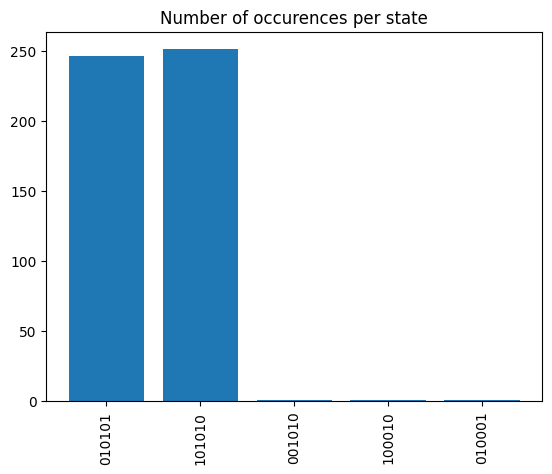

In [37]:
for job_id, sampled_res in result.get_available_results().items():
    counter = sampled_res.bitstring_counts
    plt.bar(list(counter.keys()), list(counter.values()))
    plt.xticks(rotation="vertical")
    plt.title("Number of occurences per state")
    plt.show()

This is an Antiferromagnetic state ! We have successfully brought our qubits from the state $\left|gggggg\right>$ into a mixture of the checkerboard states $\left|grgrgr\right>$ and $\left|rgrgrg\right>$ (each with a probability close to $\frac{1}{2}$).